In [ ]:
import os
import cv2
import torch
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Define dataset path

In [ ]:
data_path = "./release-raw/train"
output_csv = "eda_results.csv"

# Define dataset class


In [ ]:
class EyeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = []
        
        for label in ["RG", "NRG"]:
            label_path = os.path.join(root_dir, label)
            self.image_files.extend([(os.path.join(label_path, f), label) for f in os.listdir(label_path) if f.endswith(".jpg")])
        
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        return image, os.path.basename(img_path), label

# Define transformations

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Load dataset

In [ ]:
dataset = EyeDataset(root_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Function to visualize images with labels

In [ ]:
def visualize_sample(image, title="Image"):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to outline optic nerve head and retinal nerve fibers

In [ ]:
def highlight_regions(image):
    # Ensure image is in uint8 format (0-255)
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    # Ensure thresholded image is also uint8
    thresh = cv2.normalize(thresh, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    outlined = image_uint8.copy()
    cv2.drawContours(outlined, contours, -1, (0, 255, 0), 2)

    return outlined


# Function to compute Cup-to-Disc Ratio (CDR)


In [ ]:
def compute_cdr(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Convert grayscale image to uint8 (0-255)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Ensure at least two contours are detected (cup and disc)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    if len(contours) < 2:
        return 0  # Return default CDR if no valid contours

    disc_area = cv2.contourArea(contours[0])
    cup_area = cv2.contourArea(contours[1])

    cdr = cup_area / disc_area if disc_area != 0 else 0
    return round(cdr, 2)


# Function to detect disc hemorrhages


In [ ]:
def detect_disc_hemorrhage(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges

# Process images and save to CSV


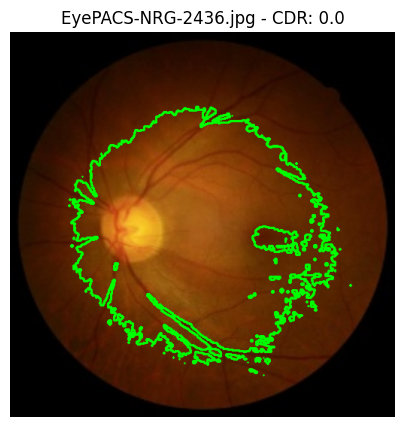

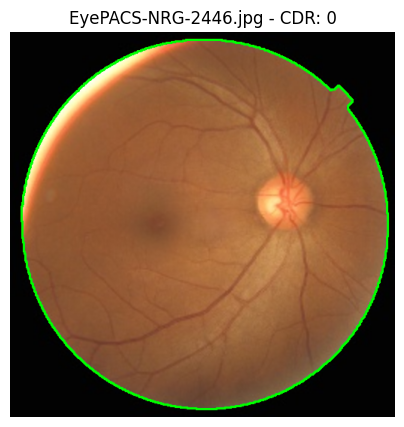

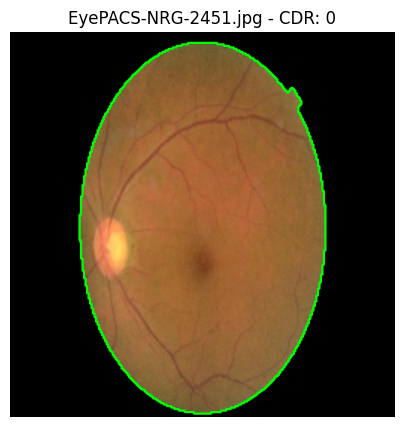

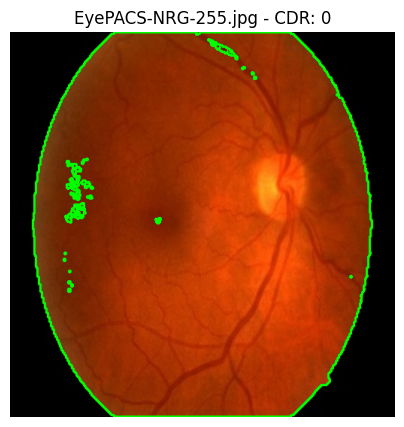

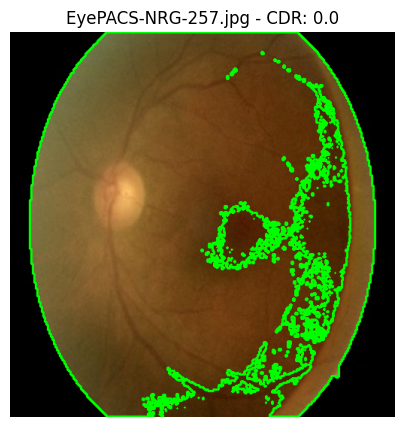

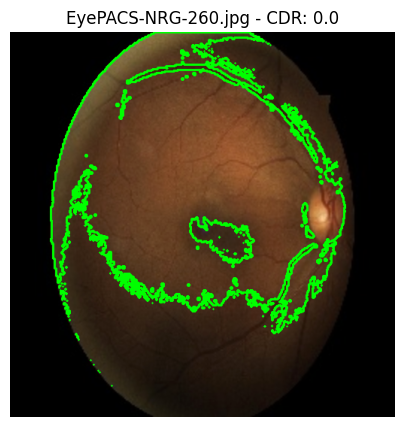

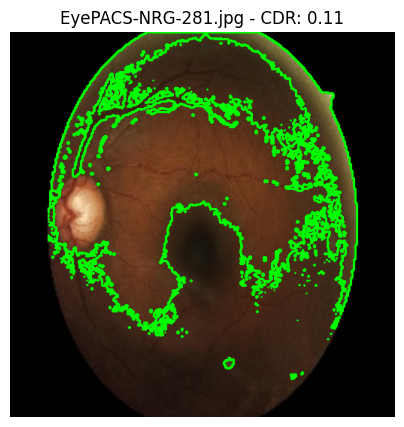

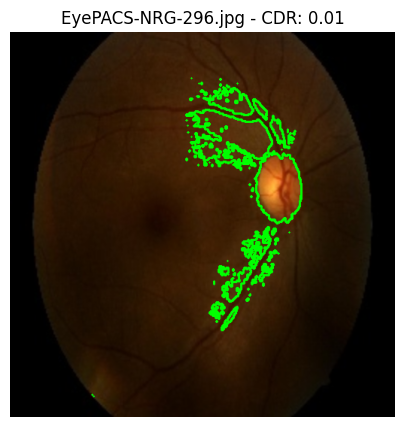

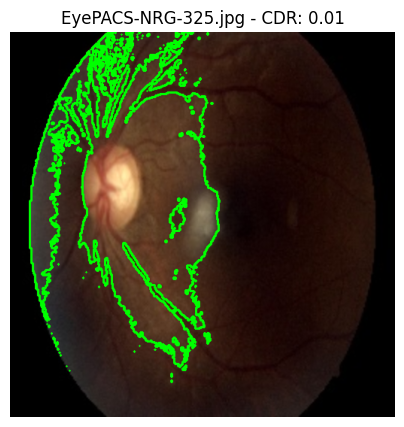

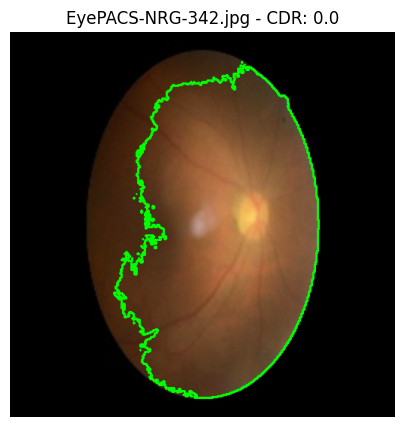

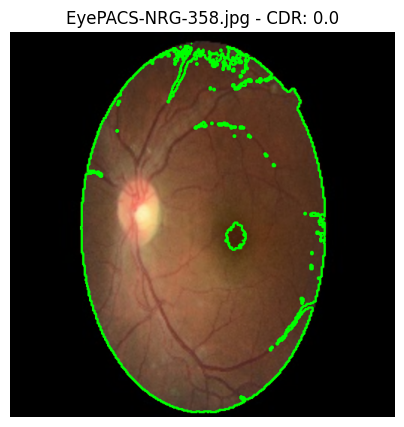

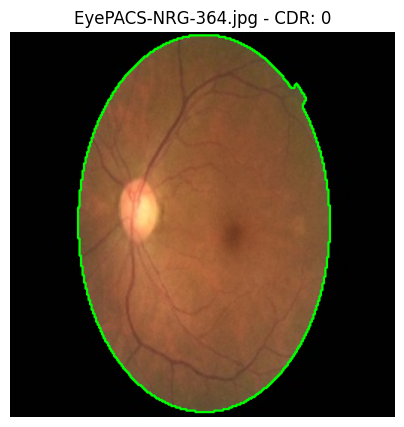

KeyboardInterrupt: 

In [10]:
results = []
for image, filename, label in dataset:
    img_array = image.permute(1, 2, 0).numpy()
    cdr = compute_cdr(img_array)
    results.append([filename, label, cdr])

    if random.random() < 0.05: 
        outlined_img = highlight_regions(img_array)
        visualize_sample(outlined_img, title=f"{filename} - CDR: {cdr}")

# Save results to CSV


In [ ]:
df = pd.DataFrame(results, columns=["name_of_train_image", "label", "cdr"])
df.to_csv(output_csv, index=False)

print(f"EDA completed. Results saved to {output_csv}")